<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/4_xr_Annotations_classification_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
!pip install netcdf4

In [23]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
#from sklearn code

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
features_path_CPA = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/finals/annot_psd_25noise_CPA.csv'
features_path_neutral = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/finals/annot_psd_25noise_neutral.csv'
features_path = [features_path_CPA, features_path_neutral]

In [27]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

annot_features_df.dropna(axis=0, inplace=True)
annot_features_df.replace('low ', 'low', inplace=True)
annot_features_df.replace('BBC', 'bbc', inplace=True)
annot_features_df.replace('low mulit', 'low multi', inplace=True)
annot_features_df.replace('medium', 'mid', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(930, 264)
Your data frame is complete
(528, 264)
Your data frame is complete
(1458, 264)


,Unnamed: 0,Annotation,animal_number,exp,key_0,session,time_stamp,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0
0,0,low,533,cFos,46305.0,CPApost,46305.0,6.763720,14.706246,17.157463,18.777504,18.801280,18.941020,21.680689,27.010199,31.726042,33.947136,38.485560,54.176230,82.596886,112.777950,135.03712,160.89626,217.36815,309.66656,395.23175,413.75125,350.99774,259.22390,200.90694,184.60960,182.10094,207.54623,339.3140,624.46860,969.45435,1171.06670,1088.68650,780.08765,448.83173,260.03458,220.98010,232.13576,218.74083,189.56561,186.19339,213.93350,237.66530,227.68307,189.67497,151.86761,136.24689,144.80156,164.37064,179.38522,184.11285,186.44768,197.38123,215.27240,225.19849,217.05745,198.62338,184.05447,174.26591,159.80649,142.31747,137.49170,148.50291,152.92119,140.22217,160.43666,302.03650,590.51794,913.5826,1079.5602,975.65704,670.1426,351.63180,169.54243,135.51057,163.7133,177.80469,166.21574,153.89922,152.84329,151.99266,140.62813,123.467620,111.53075,108.444970,110.520905,114.80608,121.00266,126.66308,125.73870,114.230774,95.701416,79.396910,72.784470,76.05185,83.193950,87.745224,87.674255,85.516785,84.44160,84.653625,83.854000,80.778470,77.178820,75.550220,75.460130

In [8]:
annot_features_df['Annotation'].value_counts()

rand_noise     1075
bbc             139
low             121
high             47
low multi        46
low complex      20
high multi        5
mid               5
Name: Annotation, dtype: int64

In [28]:
#create class column (noise = 0, USV = 1)
annot_features_df['class'] = np.where(annot_features_df['Annotation']=='rand_noise', 0, 1)
print(annot_features_df['class'].value_counts())

#create subsets of data based on experimental condition and/or session

#by session type
CPA_sessions = annot_features_df[annot_features_df['session'] == 'CPApost']
print('CPA_sessions', CPA_sessions.shape)
neutral_sessions = annot_features_df[annot_features_df['session'] == 'neutral']
print('neutral_sessions', neutral_sessions.shape)

#no round 2 (very different background noise pattern)
noR2 = annot_features_df[annot_features_df['exp'] != 'round2']
print('no round 2', noR2.shape)
noR2_CPAonly = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['session'] == 'CPApost')]
print('noR2_CPAonly', noR2_CPAonly.shape)

low_and_noise = ['low', 'low multi', 'low complex', 'rand_noise']
lowonly = annot_features_df[annot_features_df['Annotation'].isin(low_and_noise)]
print('lowonly', lowonly.shape)
lowonly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(low_and_noise))]
print('lowonly_noR2', lowonly_noR2.shape)
lowonly_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(low_and_noise))]
print('lowonly_CPAonly', lowonly_CPAonly.shape)

BBC_and_noise = ['bbc', 'rand_noise']
BBConly = annot_features_df[annot_features_df['Annotation'].isin(BBC_and_noise)]
print('BBConly', BBConly.shape)
BBConly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(BBC_and_noise))]
print('BBConly_noR2', BBConly_noR2.shape)
BBConly_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(BBC_and_noise))]
print('BBConly_CPAonly', BBConly_CPAonly.shape)

high_and_noise = ['high', 'high multi', 'rand_noise']
highonly = annot_features_df[annot_features_df['Annotation'].isin(high_and_noise)]
print('highonly', highonly.shape)
highonly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(high_and_noise))]
print('highonly_noR2', highonly_noR2.shape)
high_and_noise_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(high_and_noise))]
print('high_and_noise_CPAonly', high_and_noise_CPAonly.shape)

noise = ['rand_noise']
noiseonly = annot_features_df[annot_features_df['Annotation'].isin(noise)]
print('noiseonly', noiseonly.shape)
USVs = ['low', 'low multi', 'low complex', 'mid', 'bbc', 'high', 'high multi']
USVsonly = annot_features_df[annot_features_df['Annotation'].isin(USVs)]
print('USVsonly', USVsonly.shape)

0    1075
1     383
Name: class, dtype: int64
CPA_sessions (930, 265)
neutral_sessions (528, 265)
no round 2 (818, 265)
noR2_CPAonly (549, 265)
lowonly (1262, 265)
lowonly_noR2 (715, 265)
lowonly_CPAonly (462, 265)
BBConly (1214, 265)
BBConly_noR2 (605, 265)
BBConly_CPAonly (458, 265)
highonly (1127, 265)
highonly_noR2 (593, 265)
high_and_noise_CPAonly (458, 265)
noiseonly (1075, 265)
USVsonly (383, 265)


In [0]:
#upsampling code avaliable at end of notebook (did not improve model)
#annomaly detection code avaliable at end of notebook (did not improve model)
#multi label code avaliable at end of notebook (did not improve model)

#separate and save for later testing dataset
train, test = train_test_split(annot_features_df, test_size=0.3, random_state=1, stratify = annot_features_df['Annotation'])

#separate and save features for train and test sets
train_features = train.loc[:, '0.0':'125.0']
test_features = test.loc[:, '0.0':'125.0']

#separate and save class labels for train and test sets
train_class = train['class']
test_class = test['class']

#center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

#stratified kfold
strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(train_features_scaled, train_class))

#instantiate models with balanced class weights
lr_cv = LogisticRegression(random_state=0, class_weight='balanced')
rf_cv = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
svm_cv = SVC(probability=True, class_weight='balanced') 

In [30]:
y_pred_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(train_class, y_pred_lr)
print(conf_mat_lr)
# calculate some of these metrics using sklearn and the test set samples
print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_lr[:,1]))
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_lr))
print("F1:", metrics.f1_score(train_class,y_pred_lr))
print('\n')

y_pred_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(train_class, y_pred_rf)
print(conf_mat_rf)
# calculate some of these metrics using sklearn and the test set samples
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_rf[:,1]))
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class, y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(train_class, y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(train_class, y_pred_rf))
print("F1:", metrics.f1_score(train_class, y_pred_rf))
print('\n')

y_pred_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(train_class, y_pred_svm)
print(conf_mat_svm)
# calculate some of these metrics using sklearn and the test set samples
print("SVM ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_svm[:,1]))
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_svm))
print("F1:", metrics.f1_score(train_class,y_pred_svm))


[[654  98]
 [109 159]]
Logistic regression ROC_AUC:  0.7703313551921245
Sensitivity/Recall (TPR):  0.5932835820895522
Precision (PPV):  0.6186770428015564
Accuracy:  0.7970588235294118
F1: 0.6057142857142859


[[719  33]
 [130 138]]
Random forest ROC_AUC:  0.8742036162273736
Sensitivity/Recall (TPR):  0.5149253731343284
Precision (PPV):  0.8070175438596491
Accuracy:  0.8401960784313726
F1: 0.6287015945330295


[[735  17]
 [132 136]]
SVM ROC_AUC:  0.853810237376945
Sensitivity/Recall (TPR):  0.5074626865671642
Precision (PPV):  0.8888888888888888
Accuracy:  0.8539215686274509
F1: 0.6460807600950118


In [31]:
#once you have decided on the model and hyperparameters, fit the model using the train data
lr_cv.fit(train_features_scaled, train_class) 
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class)

#test model using test data and theshold of 0.5
print('Logistic regression test AUC: {}'.format(lr_cv.score(test_features_scaled, test_class)))
test_pred_lr = lr_cv.predict(test_features_scaled)
test_pred_prob_lr = lr_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_lr))
print(confusion_matrix(test_class, test_pred_lr))

#test model using test data and theshold of 0.5
print('Random forest test AUC: {}'.format(rf_cv.score(test_features_scaled, test_class)))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
print(confusion_matrix(test_class, test_pred_rf))

#test model using test data and theshold of 0.5
print('SVM test AUC: {}'.format(svm_cv.score(test_features_scaled, test_class)))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
print(confusion_matrix(test_class, test_pred_svm))


#pickel model to save for later use
#save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


#pkl_filename = str(save_path + "trained_pickle_model_psd_rf_full_500noise_clean.pkl")  
#with open(pkl_filename, 'wb') as file:  
#    pickle.dump(rf_cv, file)
    
#pickel model to save for later use
#save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


#pkl_filename = str(save_path + "trained_pickle_model_psd_svm_full_500noise_clean.pkl")  
#with open(pkl_filename, 'wb') as file:  
#    pickle.dump(svm_cv, file)

Logistic regression test AUC: 0.6894977168949772
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       323
           1       0.44      0.70      0.54       115

    accuracy                           0.69       438
   macro avg       0.65      0.69      0.65       438
weighted avg       0.76      0.69      0.71       438

[[221 102]
 [ 34  81]]
Random forest test AUC: 0.6940639269406392
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       323
           1       0.43      0.55      0.48       115

    accuracy                           0.69       438
   macro avg       0.63      0.65      0.63       438
weighted avg       0.72      0.69      0.70       438

[[241  82]
 [ 52  63]]
SVM test AUC: 0.8470319634703196
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       323
           1       0.89      0.48      0.62       115

    accurac

Confusion matrix, without normalization
[[221 102]
 [ 34  81]]


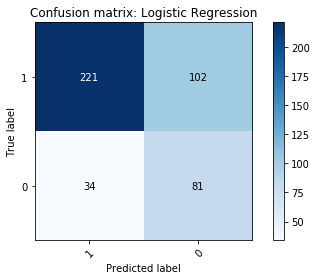

Confusion matrix, without normalization
[[241  82]
 [ 52  63]]


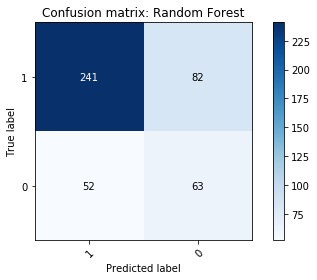

Confusion matrix, without normalization
[[316   7]
 [ 60  55]]


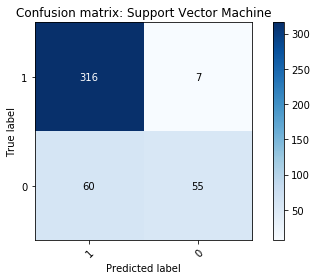

In [32]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_lr, classes=test_class, normalize=False,
                      title='Confusion matrix: Logistic Regression')



plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_rf, classes=test_class, normalize=False,
                      title='Confusion matrix: Random Forest')



plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_svm, classes=test_class, normalize=False,
                      title='Confusion matrix: Support Vector Machine')



plt.show()

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

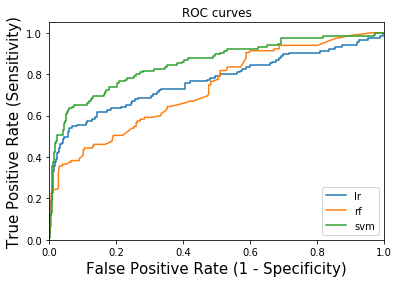

In [33]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(test_class, test_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(test_class, test_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(test_class, test_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

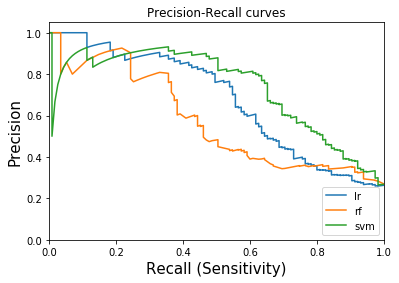

In [34]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(test_class, test_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(test_class, test_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(test_class, test_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Precision-Recall curves')
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

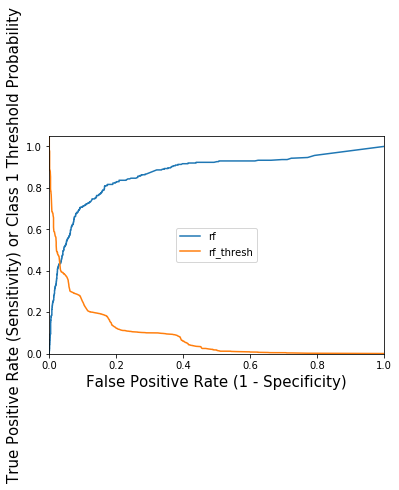

In [0]:
# plot best model with thresholds
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_rf, thresholds_rf, label="rf_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [0]:
#create new columns for each model's pred prob and the best model's pred class
train['pred_prob_lr'] = y_pred_prob_lr[:,1]
train['pred_prob_rf'] = y_pred_prob_rf[:,1]
train['pred_prob_svm'] = y_pred_prob_svm[:,1]
train['class_rf'] = y_pred_rf
train['class_svm'] = y_pred_svm
train.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm
27,27,307800.0,624,CPApost,307800.0,bbc,565.376100,1179.122700,1178.788500,1004.604250,938.700500,1379.81050,2204.45680,2820.52660,3032.55030,3491.86000,4865.70260,6766.97200,8274.06600,9946.56200,14746.84700,25760.9340,42250.00800,58249.8000,66027.27000,61781.6100,48412.70300,32932.5400,21206.36500,14768.93200,11732.66300,9750.60300,7858.93460,6184.75900,4881.62060,3785.98070,2805.43210,2138.32900,1950.66410,2031.77500,1976.33060,1698.22770,1611.7677,2193.65900,3378.24410,4467.38870,4700.78120,3926.02930,2698.59230,1740.84010,1338.51340,1254.48350,1136.79530,901.38840,708.80023,678.34360,735.73840,734.97880,637.12054,516.82410,436.78470,381.84440,316.11856,249.61897,217.92100,222.27016,225.81203,206.72853,187.58057,201.80899,247.06853,285.85020,286.65890,252.84537,211.72568,185.66164,177.52136,177.03076,173.407360,162.330540,146.47874,132.613330,126.78998,129.95690,137.41965,142.88246,143.210020,139.57053,134.81750,130.57747,126.699295,122.403656,116.991516,109.644840,99.827340,88.96887,81.372475,81.796

In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
  preds = []
  for index, row in dataframe.iterrows():
      if (row['class'] == 0) & (row[model_name] == 0):
          pred = 'TN'
      if (row['class'] == 0) & (row[model_name] == 1):
          pred = 'FP'
      if (row['class'] == 1) & (row[model_name] == 1):
          pred = 'TP'
      if (row['class'] == 1) & (row[model_name] == 0):
          pred = 'FN'
          
      preds.append(pred)
      
  dataframe[str('pred_' + model_name)] = preds
  return dataframe

In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
train = conf_mat_column(train, model_name)
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm,pred_class_rf,pred_class_svm
27,27,307800.0,624,CPApost,307800.0,bbc,565.376100,1179.122700,1178.788500,1004.604250,938.700500,1379.81050,2204.45680,2820.52660,3032.55030,3491.86000,4865.70260,6766.97200,8274.06600,9946.56200,14746.84700,25760.9340,42250.00800,58249.8000,66027.27000,61781.6100,48412.70300,32932.5400,21206.36500,14768.93200,11732.66300,9750.60300,7858.93460,6184.75900,4881.62060,3785.98070,2805.43210,2138.32900,1950.66410,2031.77500,1976.33060,1698.22770,1611.7677,2193.65900,3378.24410,4467.38870,4700.78120,3926.02930,2698.59230,1740.84010,1338.51340,1254.48350,1136.79530,901.38840,708.80023,678.34360,735.73840,734.97880,637.12054,516.82410,436.78470,381.84440,316.11856,249.61897,217.92100,222.27016,225.81203,206.72853,187.58057,201.80899,247.06853,285.85020,286.65890,252.84537,211.72568,185.66164,177.52136,177.03076,173.407360,162.330540,146.47874,132.613330,126.78998,129.95690,137.41965,142.88246,143.210020,139.57053,134.81750,130.57747,126.699295,122.403656,116.991516,109.644840,99.827

In [0]:
train.groupby('Annotation')['pred_class_rf'].value_counts()

Annotation   pred_class_rf
bbc          TP                 57
             FN                 41
high         FN                 25
             TP                  9
high multi   FN                  3
             TP                  1
low          FN                 98
             TP                 15
low complex  FN                 10
             TP                  6
low multi    FN                 19
             TP                 16
rand_noise   TN               2944
             FP                 65
Name: pred_class_rf, dtype: int64

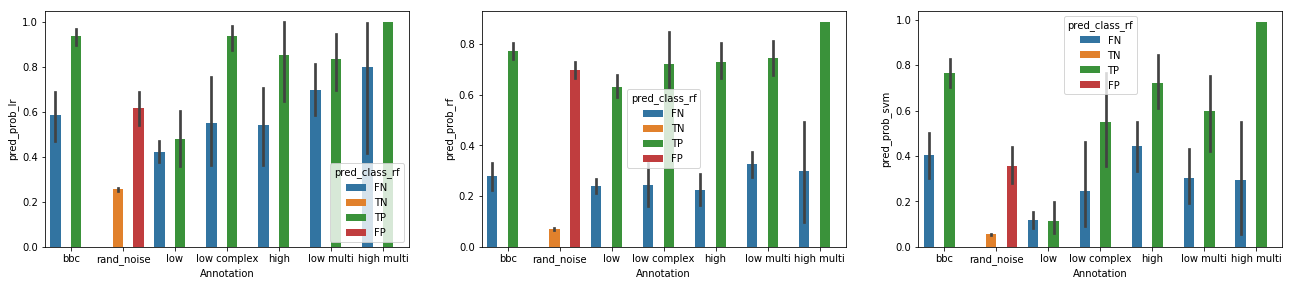

In [0]:
#viz of feature vs. pred group
feat_col = train.loc[:, 'pred_prob_lr':'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_rf", data=train)
    i = i + 1

In [0]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/netcdf_files/CPA'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
  data = xr.open_dataset(str(netcdf_path + '/' + row['animal_number'] + '_' + row['session'] + '_xr_Dataset.nc'))
    
  data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
  times = data['times'].values
  freqs = data['freq'].values
    
  max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
  #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
  plt.subplot(dim, dim, i)
  xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
  i = i + 1

TypeError: ignored

<Figure size 1080x1080 with 0 Axes>

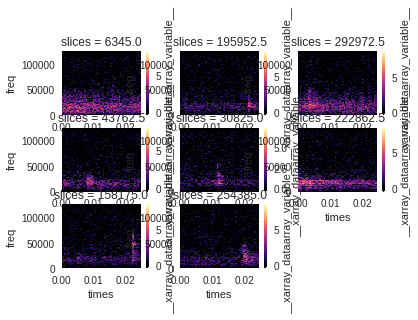

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [0]:
#once you have decided on the model and hyperparameters, fit the model using the train data
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
#test model using test data and theshold of 0.5
print(rf_cv.score(test_features_scaled, test_class))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
confusion_matrix(test_class, test_pred_rf)

0.7738095238095238
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       120
           1       0.71      0.35      0.47        48

    accuracy                           0.77       168
   macro avg       0.75      0.65      0.66       168
weighted avg       0.76      0.77      0.75       168



array([[113,   7],
       [ 31,  17]])

In [0]:
#test model using test data and theshold of 0.5
print('SVM test AUC: {}'.format(svm_cv.score(test_features_scaled, test_class)))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
confusion_matrix(test_class, test_pred_svm)

SVM test AUC: 0.8470319634703196
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       323
           1       0.89      0.48      0.62       115

    accuracy                           0.85       438
   macro avg       0.86      0.73      0.76       438
weighted avg       0.85      0.85      0.83       438



array([[316,   7],
       [ 60,  55]])

In [0]:
#create new column for model pred porb
test['pred_prob_rf'] = test_pred_prob_rf[:,1]
test['class_rf'] = test_pred_rf
test['pred_prob_svm'] = test_pred_prob_svm[:,1]
test['class_svm'] = test_pred_svm

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
test = conf_mat_column(test, model_name)
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Unnamed: 0,key_0,animal_number,session,time_stamp,Annotation,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class,pred_prob_rf,class_rf,pred_prob_svm,class_svm,pred_class_rf,pred_class_svm
152,49,204975.0,527,neutral,204975.0,rand_noise,22.270145,103.285150,274.30050,534.391200,831.873840,1094.457200,1258.32570,1295.998800,1221.34390,1077.39860,927.44183,847.76740,897.13885,1063.37050,1240.87000,1290.70090,1150.1820,886.6253,634.1499,477.1554,400.3429,342.98315,278.0816,226.68259,211.32974,221.49153,230.25366,228.78499,231.31487,251.26553,283.83320,312.75020,326.04654,321.93380,304.89870,281.50388,258.41898,239.81107,225.17310,211.20625,196.31685,182.32265,172.01419,166.68225,166.21797,169.42053,172.52782,169.10054,155.01343,135.26773,123.74406,132.40723,158.85667,185.74756,194.75336,181.98793,159.47163,142.24754,136.10309,138.27788,146.64366,163.21979,187.38474,209.38841,215.13951,198.47585,167.09375,135.86330,115.72577,109.299706,114.080734,125.87203,138.67640,145.05270,140.62668,128.88417,119.360530,119.32202,127.34451,135.76366,139.05421,138.76178,140.17833,145.537120,151.631500,153.62517,149.78726,142.130940,133.646800,126.08157,119.955650,115.311910,111.88139,109.2021

In [0]:
test.groupby('Annotation')['pred_class_svm'].value_counts()

Annotation   pred_class_svm
bbc          TP                  37
             FN                   5
high         TP                  12
             FN                   2
high multi   TP                   1
low          FN                  34
             TP                  15
low complex  TP                   6
             FN                   1
low multi    TP                  13
             FN                   2
rand_noise   TN                1138
             FP                 153
Name: pred_class_svm, dtype: int64

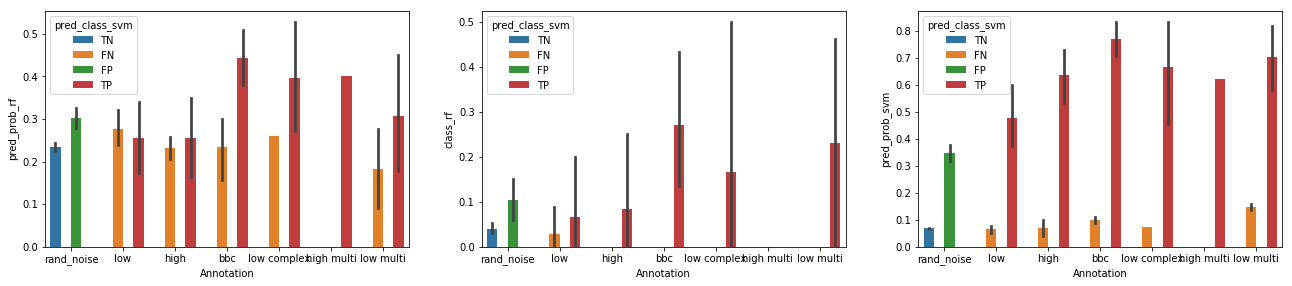

In [0]:
#viz of feature vs. pred group
feat_col = test.loc[:, 'pred_prob_rf':'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_svm", data=test)
    i = i + 1

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_psd_rf_alldata.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(rf_cv, file)

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_psd_svm_alldata.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [0]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  perplexity=50.0, n_iter=5000)
tsne_features = tsne.fit_transform(train_features_scaled)

CPU times: user 20.8 s, sys: 248 ms, total: 21 s
Wall time: 21.1 s


In [0]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = train['Unnamed: 0'])
tsne_df['label'] = train['class'].values
tsne_df['session'] = train['session'].values
tsne_df['Annotation'] = train['Annotation'].values
tsne_df['exp'] = train['exp'].values
tsne_df.head()

(1052, 2)


,tsne_0,tsne_1,label,session,Annotation,exp
Unnamed: 0,,,,,,
218,20.226562,-5.318741,1,CPApost,low,PETr1
641,-36.078053,-5.136216,0,CPApost,rand_noise,round2
473,-26.145899,-4.312085,0,CPApost,rand_noise,round2
266,22.717033,4.568873,0,CPApost,rand_noise,PETr1
53,-3.735846,4.414276,1,CPApost,high,cFos


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

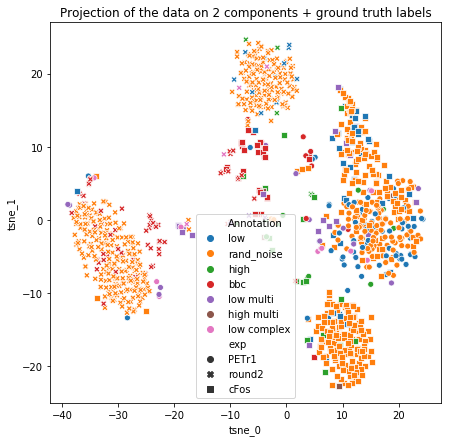

In [0]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'Annotation', style= 'exp', data = tsne_df)
plt.title("Projection of the data on 2 components + ground truth labels")

In [0]:
#upsample minority class (can skip this step if sufficient annotated samples)
majority_class = 'rand_noise'
train_maj = train[train['Annotation'] == majority_class]
train_min = train[train['Annotation'] != majority_class]

train_min_upsamples = resample(train_min, replace=True, n_samples = len(train_maj), random_state = 123)

train_upsamples = pd.concat([train_min_upsamples, train_maj])

print(train_upsamples['Annotation'].value_counts())

train_upsamples.head()

rand_noise     752
low            265
bbc            250
high           104
low multi       80
low complex     44
high multi       9
Name: Annotation, dtype: int64


,Unnamed: 0,Annotation,animal_number,exp,key_0,session,time_stamp,0.0,0.48828125,0.9765625,1.46484375,1.953125,2.44140625,2.9296875,3.41796875,3.90625,4.39453125,4.8828125,5.37109375,5.859375,6.34765625,6.8359375,7.32421875,7.8125,8.30078125,8.7890625,9.27734375,9.765625,10.25390625,10.7421875,11.23046875,11.71875,12.20703125,12.6953125,13.18359375,13.671875,14.16015625,14.6484375,15.13671875,15.625,16.11328125,16.6015625,17.08984375,17.578125,18.06640625,18.5546875,19.04296875,19.53125,20.01953125,20.5078125,20.99609375,21.484375,21.97265625,22.4609375,22.94921875,23.4375,23.92578125,24.4140625,24.90234375,25.390625,25.87890625,26.3671875,26.85546875,27.34375,27.83203125,28.3203125,28.80859375,29.296875,29.78515625,30.2734375,30.76171875,31.25,31.73828125,32.2265625,32.71484375,33.203125,33.69140625,34.1796875,34.66796875,35.15625,35.64453125,36.1328125,36.62109375,37.109375,37.59765625,38.0859375,38.57421875,39.0625,39.55078125,40.0390625,40.52734375,41.015625,41.50390625,41.9921875,42.48046875,42.96875,43.45703125,43.9453125,44.43359375,44.921875,45.41015625,45.8984375,46.38671875,46.875,47.36328125,47.8515625,48.33984375,48.828125,49.31640625,49.8046875,50.29296875,50.78125,51.26953125,51.7578125,52.24609375,52.734375,53.22265625,53.7109375,54.19921875,54.6875,55.17578125,55.6640625,56.15234375,56.640625,57.12890625,57.6171875,58.10546875,58.59375,59.08203125,59.5703125,60.05859375,60.546875,61.03515625,61.5234375,62.01171875,62.5,62.98828125,63.4765625,63.96484375,64.453125,64.94140625,65.4296875,65.91796875,66.40625,66.89453125,67.3828125,67.87109375,68.359375,68.84765625,69.3359375,69.82421875,70.3125,70.80078125,71.2890625,71.77734375,72.265625,72.75390625,73.2421875,73.73046875,74.21875,74.70703125,75.1953125,75.68359375,76.171875,76.66015625,77.1484375,77.63671875,78.125,78.61328125,79.1015625,79.58984375,80.078125,80.56640625,81.0546875,81.54296875,82.03125,82.51953125,83.0078125,83.49609375,83.984375,84.47265625,84.9609375,85.44921875,85.9375,86.42578125,86.9140625,87.40234375,87.890625,88.37890625,88.8671875,89.35546875,89.84375,90.33203125,90.8203125,91.30859375,91.796875,92.28515625,92.7734375,93.26171875,93.75,94.23828125,94.7265625,95.21484375,95.703125,96.19140625,96.6796875,97.16796875,97.65625,98.14453125,98.6328125,99.12109375,99.609375,100.09765625,100.5859375,101.07421875,101.5625,102.05078125,102.5390625,103.02734375,103.515625,104.00390625,104.4921875,104.98046875,105.46875,105.95703125,106.4453125,106.93359375,107.421875,107.91015625,108.3984375,108.88671875,109.375,109.86328125,110.3515625,110.83984375,111.328125,111.81640625,112.3046875,112.79296875,113.28125,113.76953125,114.2578125,114.74609375,115.234375,115.72265625,116.2109375,116.69921875,117.1875,117.67578125,118.1640625,118.65234375,119.140625,119.62890625,120.1171875,120.60546875,121.09375,121.58203125,122.0703125,122.55859375,123.046875,123.53515625,124.0234375,124.51171875,125.0,class
207,207,low,655,PETr1,516487.5,CPApost,516487.5,321.934020,647.554800,583.926400,392.819520,231.314210,315.208100,574.627400,686.13824,551.872440,551.51794,1070.73860,1870.62730,2342.22000,2649.59100,4356.77640,9352.05100,17831.12500,27489.3890,34999.3240,38388.6600,37987.7580,35294.08000,31336.4120,26305.65800,20412.98600,14539.87300,9813.19200,6731.23900,4926.21200,3731.99440,2802.56900,2169.67680,1901.34300,1877.43140,1876.04370,1759.31820,1533.17550,1282.33630,1094.11490,1022.10990,1072.75120,1203.71810,1341.25240,1411.53440,1370.39720,1222.71300,1024.51660,855.59174,766.97314,742.11130,712.96120,623.18400,480.53550,348.70898,288.17136,303.07730,341.69510,345.25354,296.84586,226.89217,176.77135,161.35341,165.48337,169.05745,167.51524,167.91179,172.90695,175.35683,167.540920,150.40913,131.842480,118.54751,111.88796,110.11516,111.742230,115.99986,121.488100,125.75594,126.444664,122.88521,117.01139,112.77722,113.690850,119.585434,125.52789,125.027504,115.702310,102.122940,92.34248,90.85825,94.817110,97.203180,93.631080,86.04416,80.311610,80.73079,86.532555,

In [0]:
#generate a 'groups' variable to use with group kfold
groups = train['Unnamed: 0'].values

group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(train_features_scaled, train_class, groups))

In [0]:
#annomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

#prepare data
#separate and save for later testing dataset
train, test = train_test_split(annot_features_df, test_size=0.3, random_state=1, stratify = annot_features_df['Annotation'])
#separate and save features for train and test sets
train_features = train.loc[:, '0.0':'125.0']
test_features = test.loc[:, '0.0':'125.0']

#center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)
test_features_annomaly_scaled = scaler.fit_transform(test_features_annomaly)

# fit the model
rf_annomaly = IsolationForest(behaviour='new', max_samples=100,
                      random_state=0, contamination=0.02)
rf_annomaly.fit(train_features_scaled)
y_pred_train_rf = rf_annomaly.predict(train_features_scaled)
y_pred_test_rf = rf_annomaly.predict(test_features_scaled)
train['y_pred_train_rf'] = y_pred_train_rf
test['y_pred_test_rf'] = y_pred_test_rf

ee_annomaly = EllipticEnvelope(random_state=0, contamination=0.02)
ee_annomaly.fit(train_features_scaled)
y_pred_train_ee = ee_annomaly.predict(train_features_scaled)
y_pred_test_ee = ee_annomaly.predict(test_features_scaled)
train['y_pred_train_ee'] = y_pred_train_ee
test['y_pred_test_ee'] = y_pred_test_ee

test.groupby('y_pred_test_rf')['Annotation'].value_counts()
#train.groupby('y_pred_train_annomaly')['Annotation'].value_counts()


In [0]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(train_features_scaled, train_class)

print("Best parameters : %s" % grid_result.best_params_)

svm_cv = SVC(**grid_result.best_params_)

# Fit..
svm_cv.fit(train_features_scaled, train_class)

#test model using test data and theshold of 0.5
print('SVM train AUC: {}'.format(svm_cv.score(train_features_scaled, train_class)))
train_pred_svm = svm_cv.predict(train_features_scaled)
#train_pred_prob_svm = svm_cv.predict_proba(train_features_scaled)
print(classification_report(train_class, train_pred_svm))
print(confusion_matrix(train_class, train_pred_svm))

#test model using test data and theshold of 0.5
print('SVM test AUC: {}'.format(svm_cv.score(test_features_scaled, test_class)))
test_pred_svm = svm_cv.predict(test_features_scaled)
#test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
print(confusion_matrix(test_class, test_pred_svm))

Best parameters : {'class_weight': {0: 0.05, 1: 0.95}}
SVM train AUC: 0.9799582190886539
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15050
           1       0.43      0.47      0.45       268

    accuracy                           0.98     15318
   macro avg       0.71      0.73      0.72     15318
weighted avg       0.98      0.98      0.98     15318

[[14884   166]
 [  141   127]]
SVM test AUC: 0.9798933739527799
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6450
           1       0.44      0.50      0.46       115

    accuracy                           0.98      6565
   macro avg       0.71      0.74      0.73      6565
weighted avg       0.98      0.98      0.98      6565

[[6376   74]
 [  58   57]]


In [0]:

annot_features_df['class'] = annot_features_df['Annotation'].map({'rand_noise': 0, 'low': 1, 'low multi': 1, 'low complex': 1, 'bbc': 2, 'high': 3, 'high multi': 3, 'mid': 4})
annot_features_df['class'].unique()

array([1, 3, 2, 4, 0])